Goal:

Finish Bayesian online detection script

*    load data
*    tune parameter
*    run on all data

Update probability estimation
*    read past code
*    run using new disaggregation
    

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

** load data from April **

Data is already disaggregated

In [2]:
import json
with open('../metadata/seg in april 0822.json', 'r') as fid:
    all_seg_april = json.load(fid)

In [3]:
print len(all_seg_april)

1477


** normalize data by the average of three previous points **

In [4]:
all_seg_april_normalized = [np.array(x[0])-np.mean(x[1]) for x in all_seg_april if len(x[1])==3]

In [5]:
# define a function that trim the first n data points, or discard if len is less

def extract_first_n(data_list, n):
    return [t[:n] for t in data_list if len(t)>=n]

all_seg_april_normalized_trim50 = extract_first_n(all_seg_april_normalized, 50)

print '# segs before trimming: ', len(all_seg_april_normalized)
print '# segs after trimming: ', len(all_seg_april_normalized_trim50)


# segs before trimming:  1447
# segs after trimming:  548


** Clustering **

In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [7]:
n_clusters=6
y_pred = KMeans(n_clusters=6).fit_predict(all_seg_april_normalized_trim50)

cluster_average = []
for i_cluster in range(n_clusters):
    cluster_average.append(
        np.mean([np.mean(x) for i, x in enumerate(all_seg_april_normalized_trim50) if y_pred[i]==i_cluster])
    ) 

cluster_average_rank = np.argsort(cluster_average)[::-1]
rank_map = {cluster_average_rank[i_cluster]:i_cluster for i_cluster in range(n_clusters)} # old index:new index

y_pred_old = y_pred
y_pred = [rank_map[x] for x in y_pred]

In [8]:
all_seg_per_cluster = [[] for i in range(n_clusters) ]
for i_seg in range(len(all_seg_april_normalized_trim50)):
    all_seg_per_cluster[y_pred[i_seg]].append(all_seg_april_normalized_trim50[i_seg])

In [9]:
cluster_mean = [[] for i in range(n_clusters) ]
cluster_std = [[] for i in range(n_clusters) ]
for i_cluster in range(n_clusters):
    cluster_mean[ i_cluster ] = np.mean(np.array(all_seg_per_cluster[i_cluster]), axis=0)
    cluster_std[ i_cluster ] = np.std(np.array(all_seg_per_cluster[i_cluster]), axis=0)

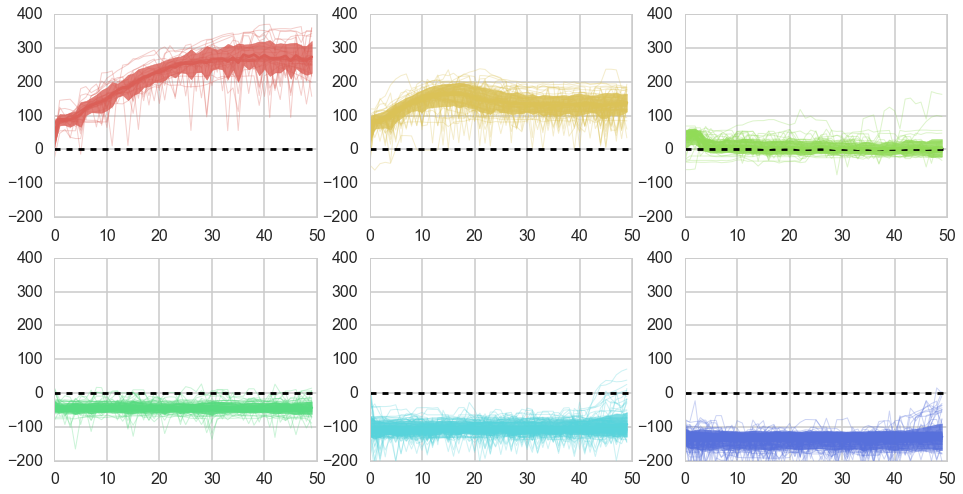

In [10]:
color_list = sns.color_palette("hls", 8)

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=[16,8]);
ax = ax.flatten()

for i_cluster in range(n_clusters):
    ax_current = ax[i_cluster]
    
    for seg in all_seg_per_cluster[i_cluster]:
        ax_current.plot(seg, '-', linewidth=1, alpha=.3, color=color_list[i_cluster])
    ax_current.set_xlim([0, 50])
    ax_current.set_ylim([-200, 400])
    ax_current.plot([0,50], [0,0], 'k--')    
    ax_current.plot(cluster_mean[i_cluster], color=color_list[i_cluster])
    ax_current.fill_between(range(50)
                            , cluster_mean[i_cluster]-cluster_std[i_cluster]
                            , cluster_mean[i_cluster]+cluster_std[i_cluster]
                            , color=color_list[i_cluster], alpha=.8)


In [11]:
with open('../metadata/cluster result.json', 'w') as fid:
    json.dump([list(t) for t in cluster_mean], fid)

### ?.? Disaggregation algorithm and parameter tuning

Let us test the idea to combine information from the learned shape and bayesian-style online detection method.
The idea is simple, for whatever method, when applied to individual segments above, should match the correct 
clustering results.

This means that, we need a disaggregate function, which takes in a series of data, return a set of change points. Since the inputs are relative simple compared to realistic data, I expect a reasonable disaggregation algorithm
will return a result that match to clustering results. 
The results depend on a set of parameters. This step idealy will be very useful to tune parameters.

function: disaggregate(data, parameter=default_parameter)
<pre>
```python
for data in all_data:
    cp = disaggregate(data)
    mistake = compare_cp_to_cluster( cp, predict_cluster(data) )
```
</pre>
The idea is to find **default_parameter** that minimize mistakes.

** Disaggregation algorithm **

After time *t*, let us imagine that we use the following summary statistics to summarize information for all previous data $y_{1:t}$.

* $P(s_i, \tau|y_{1:t})$, the probability of the last change point is due to type i change, and it happened at $t-\tau$.
$\tau$ can only be zero or positive. When it is zero, it means that the current time t is the first time point 
after change.

* $\Delta_{mean}(s_i, \tau|y_{1:t})$ and $\Delta_{var}(s_i, \tau|y_{1:t})$, 
mean and variance of the relative shift compared to the average shape.

Image we get a new data point $y_{t+1}$, we want to get the corresponding $P(..|y_{1:t+1})$, $\Delta_{mean}(..|y_{1:t+1})$, and $\Delta_{var}(..|y_{1:t+1})$

We do this by using a method similar to Kalman Filter in two steps. 
* In the prediction step, we use what is known about the shape to predict the three number of the next data point
without knowing $y_{t+1}$
* In the udpate step, we combine the previous knowledge with the new measurement.

**Step 1 in prediction step:**

$P^{t+1}(s_i, \tau | y_{1:t}) = H(s_i, \tau-1) * P^{t}(s_i, \tau-1 | y_{1:t})$, for $\tau$>0

$P^{t+1}(s_i, \tau | y_{1:t}) = P_0$, for $\tau$=0

P_0 used the assumption that all change point types are equally possible, which can be changed later. 

P_0 also makes sure that all probs can be summed to be 1

0 < H < 1, is the probability that shape i at $\tau$ will not change in the next time point. In the simplest case,
we can assume that it is the same for all shapes and $\tau$, but in principle this can be learnt in the history data.

**Step 2 in prediction step:**

$\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t}) = \Delta^{t}_{mean}(s_i, \tau-1|y_{1:t}) + shape_i(\tau)-shape_i(\tau-1)$
for $\tau$ > 0. This assumes $shape_i(0-1) = 0$.

$\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t}) = shape_i( 0 )$ for $\tau=0$

$\Delta^{t+1}_{var}(s_i, \tau|y_{1:t}) = \Delta^{t}_{var}(s_i, \tau-1|y{1:t}) + \delta_i(\tau)+Q$, 
for \tau > 0. Here $\delta$ is due to uncertainty in estimating change in average shape, which is defined as

$\delta_i = E(\delta_i(\tau)) = E (std(y(i,\tau))/\sqrt{(N_{sample})})$

Q is the process variance, a free parameter.

$\Delta^{t+1}_{var}(s_i, \tau|y_{1:t}) = \Delta_{init}$, $\Delta_{init}$ is a free parameter.

** Estimate prob **

$P_{pred}(s_i, \tau) = P(y_{t+1}|\mu=\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t}),var=\Delta^{t+1}_{var}(s_i, \tau|y_{1:t})+R)$, 
R is the variance of measurement noise.

P will tells us how different new measurement is different from previous measurement

** Update step **

Kalman coefficient: $K = \Delta^{t+1}_{var}(s_i, \tau|y_{1:t}) / (\Delta^{t+1}_{var}(s_i, \tau|y_{1:t})+R)$

Difference: $offset = y_{t+1}-\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t})$

$\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t+1}) = \Delta^{t+1}_{mean}(s_i, \tau|y_{1:t}) + K * offset$

$\Delta^{t+1}_{var}(s_i, \tau|y_{1:t+1}) = (1-K) * \Delta^{t+1}_{var}(s_i, \tau|y_{1:t})$

** Update prob **

$P^{t+1}(s_i, \tau|y_{1:t+1}) = 1/Z * P^{t}(s_i, \tau|y_{1:t}) * P_{pred}(s_i, \tau)$

or in log scale

$P_{log}^{t+1}(s_i, \tau|y_{1:t+1}) = -Z_{log} + P_{log}^{t}(s_i, \tau|y_{1:t}) + P_{log, pred}(s_i, \tau)$
, where Z is normalization factor

** define helper function to calculate log likelihood from normal distribution **

In [29]:
def log_norm_pdf(x
                 , mu
                 , sigma_2 # sigma^2
                ):
    return -(x-mu)**2/sigma_2 - np.log(2*np.pi*sigma_2)/2

In [12]:
# test log_norm_pdf
print log_norm_pdf(0,0,1)

-0.918938533205


** get a sense of variation of power usage within each segment **

In [13]:
delta_shape = [[] for i in range(n_clusters)]

for i_cluster in range(n_clusters):
    delta_shape[i_cluster] = 2*np.mean(cluster_std[i_cluster]**2 / len(all_seg_per_cluster[i_cluster]))
    print 'shape %d, average change std %1.1f' % \
    (i_cluster, 
     np.sqrt(delta_shape[i_cluster]))

shape 0, average change std 8.8
shape 1, average change std 5.0
shape 2, average change std 3.3
shape 3, average change std 2.3
shape 4, average change std 2.7
shape 5, average change std 3.2


** major function to disaggregate **

In [14]:
def set_prior_3(para):
    n_shape = para['n_shape']

    log_prob = [ [] for i_shape in range(n_shape) ]
    delta_mean = [ [] for i_shape in range(n_shape) ]
    delta_var = [ [] for i_shape in range(n_shape) ]
    time_since_last_cp = [ [] for i_shape in range(n_shape) ]
    
    return log_prob, delta_mean, delta_var, time_since_last_cp
    
def update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para):
    
    n_shape = para['n_shape']
    H = para['H']
    H_2_exp = 1-np.exp(H)
    delta_shape = para['delta_shape']
    Q = para['Q']
    R = para['R']
    shape = para['shape']
    
    # a function that return element within the shape or the last element of the list
    shape_helper = lambda i_shape, x: shape[i_shape][x] if x<len(shape[i_shape]) else shape[i_shape][-1]

    # step 1
    log_prob_grow = [ [] for _ in range(n_shape) ]
    time_since_last_cp_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_grow[i_shape] = [
            np.log(H_2_exp*1./n_shape)
        ] + [
            x + H for x in log_prob[i_shape]
        ]
        time_since_last_cp_grow[i_shape] = [0] + [x+1 for x in time_since_last_cp[i_shape]]

    # step 2
    delta_mean_grow = [ [] for _ in range(n_shape) ]
    delta_var_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        delta_mean_grow[i_shape] = [
            shape_helper(i_shape, x)+y 
            for x, y in zip(time_since_last_cp_grow[i_shape], [last_datum]+delta_mean[i_shape])
        ]
        delta_var_grow[i_shape] = [
            para['delta_init'] 
        ] + [
            x+delta_shape[i_shape]+Q for x in delta_var[i_shape]
        ]
    
    # estimate probability
    p_predict = [ [ ] for i_shape in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        tmp = [ 0 for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            tmp[i_tau] = log_norm_pdf( datum, delta_mean_grow[i_shape][i_tau], delta_var_grow[i_shape][i_tau] + R )
        p_predict[i_shape] = tmp
    
    # Update step
    delta_mean_posterior = [ [] for _ in range(n_shape)]
    delta_var_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        delta_mean_tmp = [ [] for _ in range(n_tau) ]
        delta_var_tmp = [ [] for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            K = delta_var_grow[i_shape][i_tau] / (delta_var_grow[i_shape][i_tau]+R)
            offset = datum - delta_mean_grow[i_shape][i_tau]
            delta_mean_tmp[i_tau] = delta_mean_grow[i_shape][i_tau] + K * offset
            delta_var_tmp[i_tau] = (1-K) * delta_var_grow[i_shape][i_tau]
        delta_mean_posterior[i_shape] = delta_mean_tmp
        delta_var_posterior[i_shape] = delta_var_tmp
            
    # update prob
    log_prob_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x+y for x,y in zip(log_prob_grow[i_shape], p_predict[i_shape])]

    try:
        Z = sp.misc.logsumexp([x for t in log_prob_posterior for x in t]) # normalization
    except:
        print type(log_prob_posterior),log_prob_posterior
        Z = sp.misc.logsumexp(log_prob_posterior) # normalization
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x-Z for x in log_prob_posterior[i_shape]]
        
    # discount mean
    time_since_last_cp_posterior = time_since_last_cp_grow
    for i_shape in range(n_shape):
        delta_mean_posterior[i_shape] = [x-shape_helper(i_shape, y) for x, y in zip(delta_mean_posterior[i_shape], time_since_last_cp_posterior[i_shape])]

    return log_prob_posterior, delta_mean_posterior, delta_var_posterior, time_since_last_cp_posterior

def argmax_2d(data):
    c_min = data[0][0]
    r = 0
    c = 0
    
    for c_r, l in enumerate(data):
        for c_c, t in enumerate(l):
            if t > c_min:
                r = c_r
                c = c_c
                c_min = t
    return r, c
#     data = np.array(data);
#     return np.argmax(np.max(data, axis=1)), np.argmax(np.max(data, axis=0))

def trim_prob(log_prob_posterior, 
              delta_mean_posterior, 
              delta_var_posterior,
              time_since_last_cp_posterior,
              protection_zone = 10,
              thre = 0.3
             ):
    """
    if the most-likely situation exceed the threshold, all the rest of data will be filtered unless 
    in protection zone
    """
        
    # find the maximal
    max_log_prob = np.max([x for t in log_prob_posterior for x in t ])
#     print log_prob_posterior
#     print type(log_prob_posterior), type(log_prob_posterior[0]), max_log_prob, np.array(log_prob_posterior)

    # did not trigger trimming
    if (max_log_prob < np.log(thre)):
        return log_prob_posterior, delta_mean_posterior, delta_var_posterior, time_since_last_cp_posterior

    # now find the location with max log prob
    (i_shape_max, i_time_max) = argmax_2d(log_prob_posterior)

    n_shapes = len(log_prob_posterior)
    log_prob_posterior_new = [[] for _ in range(n_shapes)]
    delta_mean_posterior_new = [[] for _ in range(n_shapes)]
    delta_var_posterior_new = [[] for _ in range(n_shapes)]
    time_since_last_cp_posterior_new = [[] for _ in range(n_shapes)]
    
    for i_shape in range(n_shapes):
        log_prob_posterior_new[i_shape] = [
            t for i, t in enumerate(log_prob_posterior[i_shape])
            if ( (time_since_last_cp_posterior[i_shape][i]<protection_zone) or ((i_shape==i_shape_max) and (i==i_time_max)) )
        ]
        delta_mean_posterior_new[i_shape] = [
            t for i, t in enumerate(delta_mean_posterior[i_shape])
            if ( (time_since_last_cp_posterior[i_shape][i]<protection_zone) or ((i_shape==i_shape_max) and (i==i_time_max)) )
        ]
        delta_var_posterior_new[i_shape] = [
            t for i, t in enumerate(delta_var_posterior[i_shape])
            if ( (time_since_last_cp_posterior[i_shape][i]<protection_zone) or ((i_shape==i_shape_max) and (i==i_time_max)) )
        ]
        time_since_last_cp_posterior_new[i_shape] = [
            t for i, t in enumerate(time_since_last_cp_posterior[i_shape])
            if ( (time_since_last_cp_posterior[i_shape][i]<protection_zone) or ((i_shape==i_shape_max) and (i==i_time_max)) )
        ]

    return log_prob_posterior_new, delta_mean_posterior_new, delta_var_posterior_new, time_since_last_cp_posterior_new

In [15]:
para = {}
para['n_shape'] = n_clusters
para['delta_init'] = 200.
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = delta_shape
para['Q'] = 100. # process error
para['R'] = 100. # measurement error
para['shape'] = cluster_mean

In [27]:
def rel_change(y):
    """
    return relative change comparing to the closer neighbouring points
    """
    return np.min([np.abs(y[1] - y[0]), np.abs(y[1] - y[2])]) / float(y[1])

def rel_change_filter_0819_3(t, data_input, thre=.2):
    """
    filter data based on relative change
    data points in data_input that below or above both neighbouring points
    and have relative change above thre will be set as the average of neighbouring data.
    """
    thre_2 = thre/(1-thre)
    id_filter = [i for i in range(1, len(data_input)-1) 
     if (data_input[i]>data_input[i-1] and data_input[i]>data_input[i+1] and rel_change(data_input[i-1:i+2])>thre) or
                 (data_input[i]<data_input[i-1] and data_input[i]<data_input[i+1] and rel_change(data_input[i-1:i+2])>thre_2)
    ]
    data_input_2 = [(data_input[i-1]+data_input[i+1])/2 if (i in id_filter) else dat for i, dat in enumerate(data_input) ]
    return t, data_input_2

** apply on an example **

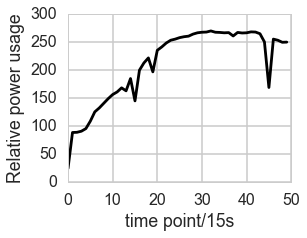

In [17]:
data = all_seg_per_cluster[0][1]

# padding the beginning and ending with some zeros
# n_padding = 60;
# data = [0 for _ in range(n_padding)] + list(data) + [0 for _ in range(n_padding)]

plt.figure(figsize=(4,3))

plt.plot(data, 'k-')

plt.xlabel('time point/15s')
plt.ylabel('Relative power usage')

as the goal is the detect the change point at the beginning, I will add a series of zeros at the beginning

In [24]:
type(data)

def add_padding_zero(data, n):
    return np.array([0 for _ in range(n)] + list(data))

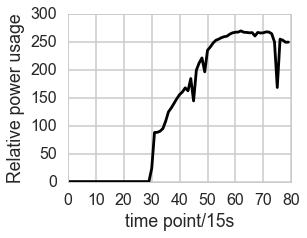

In [28]:
data = all_seg_per_cluster[0][1]

# padding the beginning and ending with some zeros
n_padding = 30;
data = add_padding_zero(data, n_padding)

plt.figure(figsize=(4,3))
plt.plot(data, 'k-')
plt.xlabel('time point/15s')
plt.ylabel('Relative power usage')

In [33]:
%%time

data = all_seg_per_cluster[0][1]
n_padding = 30;
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)

last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

for datum in data:
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
#     log_prob, delta_mean, delta_var, time_since_last_cp = trim_prob(log_prob, delta_mean, delta_var, time_since_last_cp)
    last_datum = datum
#     print type(log_prob), type(delta_mean), type(delta_var), type(time_since_last_cp)
#     print len(log_prob[0])
    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)


CPU times: user 351 ms, sys: 3.67 ms, total: 355 ms
Wall time: 398 ms


In [194]:
def query_log_prob(log_prob_list, time_since_last_cp_list, start_pos):

    n_shape = len(log_prob_list[0])
    print n_shape
    result = [[] for _ in range(n_shape)]
    
    for i in range(len(log_prob_list)):
        for j in range(n_shape):
            tmp = np.where( np.array(time_since_last_cp_list[i][j])==(i-start_pos) )
            if not tmp[0]:
                result[j].append(np.nan)
            else:
                result[j].append(log_prob_list[i][j][tmp[0]])
    return result


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


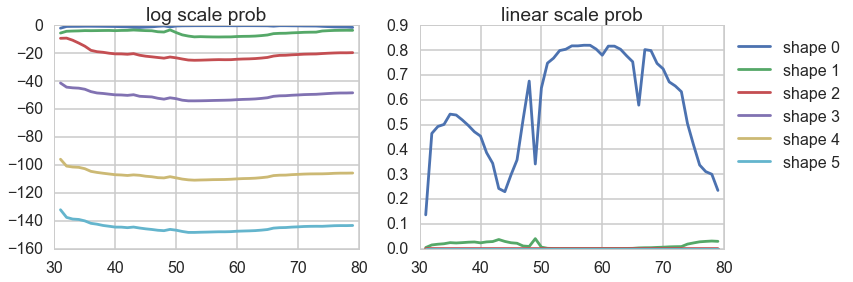

In [35]:
log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, 30)

_, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# plt.figure(figsize=(6,4))
for i in range(n_clusters):
    ax[0].plot(log_prob_trace[i], label='shape '+str(i))
ax[0].set_title( 'log scale prob' )

for i in range(n_clusters):
    ax[1].plot(np.exp(log_prob_trace[i]), label='shape '+str(i))
ax[1].set_title( 'linear scale prob' )
    
ax[1].legend(loc='bottom right', bbox_to_anchor=(1, 1))

** let us try to find a way to extract enough information about prob, so that we do not need to do so many calculation **


In [51]:
# %%time

prob_correct = []
prob_wrong = []

n_padding = 30;

for i_shape in [0]:

    n_curve = len(all_seg_per_cluster[i_shape])
    for i_curve in range(n_curve):
        print '%d/%d' % (i_curve+1, n_curve)
        
        data = all_seg_per_cluster[i_shape][i_curve]
        data = add_padding_zero(data, n_padding)
        _, data = rel_change_filter_0819_3(range(len(data)), data)

        log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)
        
        last_datum = 0
        
        log_prob_list = []
        delta_mean_list = []
        delta_var_list = []
        time_since_last_cp_list = []
        
        for datum in data:
            log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
            last_datum = datum

            log_prob_list.append(log_prob)
            delta_mean_list.append(delta_mean)
            delta_var_list.append(delta_var)
            time_since_last_cp_list.append(time_since_last_cp)
            
        log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding)
            
        prob_correct.append(log_prob_trace[0])
        prob_wrong.append(log_prob_trace[1])
        

1/32


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


2/32
3/32
4/32
5/32
6/32
7/32
8/32
9/32
10/32
11/32
12/32
13/32
14/32
15/32
16/32
17/32
18/32
19/32
20/32
21/32
22/32
23/32
24/32
25/32
26/32
27/32
28/32
29/32
30/32
31/32
32/32


** current parameter is apparently not good **

(0, 1)

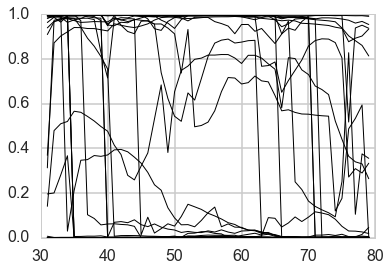

In [84]:
plt.figure(figsize=(6,4))

for t1, t2 in zip(prob_correct, prob_wrong):
    plt.plot(np.exp(t1)+np.exp(t2), linewidth=1, color='k' )
plt.ylim([0, 1])


In [86]:
np.mean([np.exp(t1[-1])+np.exp(t2[-1]) for t1, t2 in zip(prob_correct, prob_wrong)])

0.208151366795224

In [90]:
# %%time

for Q in [25, 100, 400]:
    for R in [25, 100, 400]:
        for delta_init in [50, 200, 800]:
            para = {}
            para['n_shape'] = n_clusters
            para['delta_init'] = float(delta_init)
            para['H'] = np.log(1-1./(15*4)) # 15 min per cp
            para['delta_shape'] = delta_shape
            para['Q'] = float(Q) # process error
            para['R'] = float(R) # measurement error
            para['shape'] = cluster_mean

            prob_correct = []
            prob_wrong = []

            n_padding = 30;

            for i_shape in [0]:

                n_curve = len(all_seg_per_cluster[i_shape])
                for i_curve in range(n_curve):
    #                 print '%d/%d' % (i_curve+1, n_curve)

                    data = all_seg_per_cluster[i_shape][i_curve]
                    data = add_padding_zero(data, n_padding)
                    _, data = rel_change_filter_0819_3(range(len(data)), data)

                    log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)

                    last_datum = 0

                    log_prob_list = []
                    delta_mean_list = []
                    delta_var_list = []
                    time_since_last_cp_list = []

                    for datum in data:
                        log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
                        last_datum = datum

                        log_prob_list.append(log_prob)
                        delta_mean_list.append(delta_mean)
                        delta_var_list.append(delta_var)
                        time_since_last_cp_list.append(time_since_last_cp)

                    log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding)

                    prob_correct.append(log_prob_trace[0])
                    prob_wrong.append(log_prob_trace[1])

                print Q, R, delta_init, np.mean([np.exp(t1[-1])+np.exp(t2[-1]) for t1, t2 in zip(prob_correct, prob_wrong)])

/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


25 25 50 0.127942553044
25 25 200 0.0977334607374
25 25 800 0.0811631320154
25 100 50 0.245369889489
25 100 200 0.210855821467
25 100 800 0.110742649816
25 400 50 0.493690810605
25 400 200 0.454909885674
25 400 800 0.385188613918
100 25 50 0.131056389349
100 25 200 0.130230903606
100 25 800 0.116209932894
100 100 50 0.219130786318
100 100 200 0.208151366795
100 100 800 0.16868416074
100 400 50 0.490638901594
100 400 200 0.459308458814
100 400 800 0.402611387241
400 25 50 0.24004495075
400 25 200 0.208906617574
400 25 800 0.201991586535
400 100 50 0.33298265405
400 100 200 0.284812242447
400 100 800 0.264798050772
400 400 50 0.498913170537
400 400 200 0.479500706156
400 400 800 0.411651776363


In [91]:
# %%time

for Q in [400, 800, 1600]:
    for R in [400, 800, 1600]:
        for delta_init in [50]:
# for Q in [100]:
#     for R in [100]:
#         for delta_init in [200]:
            para = {}
            para['n_shape'] = n_clusters
            para['delta_init'] = float(delta_init)
            para['H'] = np.log(1-1./(15*4)) # 15 min per cp
            para['delta_shape'] = delta_shape
            para['Q'] = float(Q) # process error
            para['R'] = float(R) # measurement error
            para['shape'] = cluster_mean

            prob_correct = []
            prob_wrong = []

            n_padding = 30;

            for i_shape in [0]:

                n_curve = len(all_seg_per_cluster[i_shape])
                for i_curve in range(n_curve):
    #                 print '%d/%d' % (i_curve+1, n_curve)

                    data = all_seg_per_cluster[i_shape][i_curve]
                    data = add_padding_zero(data, n_padding)
                    _, data = rel_change_filter_0819_3(range(len(data)), data)

                    log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)

                    last_datum = 0

                    log_prob_list = []
                    delta_mean_list = []
                    delta_var_list = []
                    time_since_last_cp_list = []

                    for datum in data:
                        log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
                        last_datum = datum

                        log_prob_list.append(log_prob)
                        delta_mean_list.append(delta_mean)
                        delta_var_list.append(delta_var)
                        time_since_last_cp_list.append(time_since_last_cp)

                    log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding)

                    prob_correct.append(log_prob_trace[0])
                    prob_wrong.append(log_prob_trace[1])

                print Q, R, delta_init, np.mean([np.exp(t1[-1])+np.exp(t2[-1]) for t1, t2 in zip(prob_correct, prob_wrong)])

/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


400 400 50 0.498913170537
400 800 50 0.490033173931
400 1600 50 0.415151113431
800 400 50 0.220942379664
800 800 50 0.1881497215
800 1600 50 0.14015173658
1600 400 50 0.0538324347337
1600 800 50 0.0494660239318
1600 1600 50 0.0402085756824


In [92]:
# %%time

for Q in [400]:
    for R in [400]:
        for delta_init in [12,25,50]:
            para = {}
            para['n_shape'] = n_clusters
            para['delta_init'] = float(delta_init)
            para['H'] = np.log(1-1./(15*4)) # 15 min per cp
            para['delta_shape'] = delta_shape
            para['Q'] = float(Q) # process error
            para['R'] = float(R) # measurement error
            para['shape'] = cluster_mean

            prob_correct = []
            prob_wrong = []

            n_padding = 30;

            for i_shape in [0]:

                n_curve = len(all_seg_per_cluster[i_shape])
                for i_curve in range(n_curve):
    #                 print '%d/%d' % (i_curve+1, n_curve)

                    data = all_seg_per_cluster[i_shape][i_curve]
                    data = add_padding_zero(data, n_padding)
                    _, data = rel_change_filter_0819_3(range(len(data)), data)

                    log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)

                    last_datum = 0

                    log_prob_list = []
                    delta_mean_list = []
                    delta_var_list = []
                    time_since_last_cp_list = []

                    for datum in data:
                        log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
                        last_datum = datum

                        log_prob_list.append(log_prob)
                        delta_mean_list.append(delta_mean)
                        delta_var_list.append(delta_var)
                        time_since_last_cp_list.append(time_since_last_cp)

                    log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding)

                    prob_correct.append(log_prob_trace[0])
                    prob_wrong.append(log_prob_trace[1])

                print Q, R, delta_init, np.mean([np.exp(t1[-1])+np.exp(t2[-1]) for t1, t2 in zip(prob_correct, prob_wrong)])

/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


400 400 12 0.50070849274
400 400 25 0.500277747433
400 400 50 0.498913170537


** why prob is so low at the end of the data? **

In [93]:
# %%time

prob_correct = []
prob_wrong = []

n_padding = 30;

para = {}
para['n_shape'] = n_clusters
para['delta_init'] = float(12)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = delta_shape
para['Q'] = float(400) # process error
para['R'] = float(400) # measurement error
para['shape'] = cluster_mean


for i_shape in [0]:

    n_curve = len(all_seg_per_cluster[i_shape])
    for i_curve in range(n_curve):
        print '%d/%d' % (i_curve+1, n_curve)
        
        data = all_seg_per_cluster[i_shape][i_curve]
        data = add_padding_zero(data, n_padding)
        _, data = rel_change_filter_0819_3(range(len(data)), data)

        log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)
        
        last_datum = 0
        
        log_prob_list = []
        delta_mean_list = []
        delta_var_list = []
        time_since_last_cp_list = []
        
        for datum in data:
            log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
            last_datum = datum

            log_prob_list.append(log_prob)
            delta_mean_list.append(delta_mean)
            delta_var_list.append(delta_var)
            time_since_last_cp_list.append(time_since_last_cp)
            
        log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding)
            
        prob_correct.append(log_prob_trace[0])
        prob_wrong.append(log_prob_trace[1])
        

1/32


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


2/32
3/32
4/32
5/32
6/32
7/32
8/32
9/32
10/32
11/32
12/32
13/32
14/32
15/32
16/32
17/32
18/32
19/32
20/32
21/32
22/32
23/32
24/32
25/32
26/32
27/32
28/32
29/32
30/32
31/32
32/32


(0, 1)

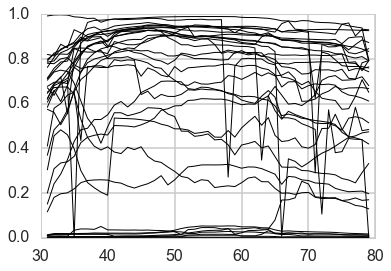

In [94]:
plt.figure(figsize=(6,4))

for t1, t2 in zip(prob_correct, prob_wrong):
    plt.plot(np.exp(t1)+np.exp(t2), linewidth=1, color='k' )
plt.ylim([0, 1])


(0, 1)

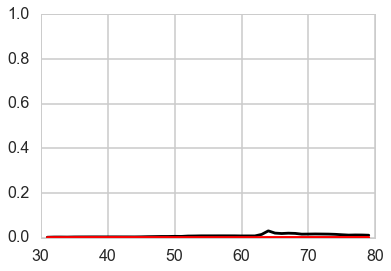

In [107]:
plt.figure(figsize=(6,4))
i = 8
plt.plot(np.exp(prob_correct[i]), 'k-')
plt.plot(np.exp(prob_wrong[i]), 'r-')
plt.ylim([0,1])

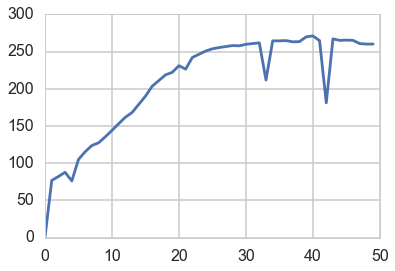

In [108]:
plt.figure(figsize=(6,4))

plt.plot(all_seg_per_cluster[0][8])

** the problem is in the training data ** 

In [112]:
# %%time

prob_correct = []
prob_wrong = []

n_padding = 30;

para = {}
para['n_shape'] = n_clusters
para['delta_init'] = float(12)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = delta_shape
para['Q'] = float(400) # process error
para['R'] = float(400) # measurement error
para['shape'] = cluster_mean


for i_shape in [0]:

    n_curve = len(all_seg_per_cluster[i_shape])
    for i_curve in range(n_curve):
        print '%d/%d' % (i_curve+1, n_curve)
        
        data = all_seg_per_cluster[i_shape][i_curve]
        data = add_padding_zero(data, n_padding)
        _, data = rel_change_filter_0819_3(range(len(data)), data)

        log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)
        
        last_datum = 0
        
        log_prob_list = []
        delta_mean_list = []
        delta_var_list = []
        time_since_last_cp_list = []
        
        for datum in data:
            log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
            last_datum = datum

            log_prob_list.append(log_prob)
            delta_mean_list.append(delta_mean)
            delta_var_list.append(delta_var)
            time_since_last_cp_list.append(time_since_last_cp)
            
        log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding)
        log_prob_trace_2 = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding+1)

        sum_no_offset = np.exp(log_prob_trace[0][-1])+np.exp(log_prob_trace[1][-1])
        sum_with_offset = np.exp(log_prob_trace_2[0][-1])+np.exp(log_prob_trace_2[1][-1])
        if (sum_no_offset>sum_with_offset):
            prob_correct.append(log_prob_trace[0])
            prob_wrong.append(log_prob_trace[1])
        else:
            prob_correct.append(log_prob_trace_2[0])
            prob_wrong.append(log_prob_trace_2[1])
        

1/32


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


2/32
3/32
4/32
5/32
6/32
7/32
8/32
9/32
10/32
11/32
12/32
13/32
14/32
15/32
16/32
17/32
18/32
19/32
20/32
21/32
22/32
23/32
24/32
25/32
26/32
27/32
28/32
29/32
30/32
31/32
32/32


(0, 1)

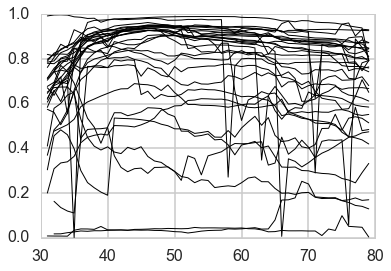

In [113]:
plt.figure(figsize=(6,4))

for t1, t2 in zip(prob_correct, prob_wrong):
    plt.plot(np.exp(t1)+np.exp(t2), linewidth=1, color='k' )
plt.ylim([0, 1])


(0, 1)

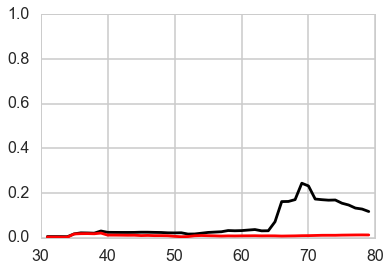

In [115]:
plt.figure(figsize=(6,4))
i = 9
plt.plot(np.exp(prob_correct[i]), 'k-')
plt.plot(np.exp(prob_wrong[i]), 'r-')
plt.ylim([0,1])

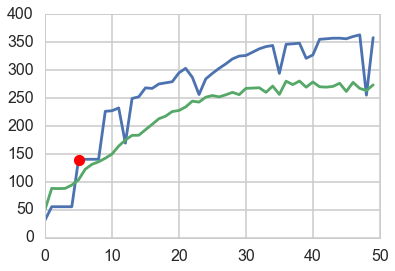

In [139]:
plt.figure(figsize=(6,4))

plt.plot(all_seg_per_cluster[0][9])
plt.plot(5, all_seg_per_cluster[0][9][5], 'ro')
plt.plot(cluster_mean[0], '')

In [140]:
data = all_seg_per_cluster[0][9]
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)

last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

for datum in data:
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)

# log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding+1)
# plt.plot(log_prob_trace[0][2])
print argmax_2d(log_prob_list[-1])
log_prob_list[-1][1][40]
time_since_last_cp_list[-1][1][40]

(1, 40)


40

In [131]:
print [(i, i-argmax_2d(t)[1])for i, t in enumerate(log_prob_list)]
# argmax_2d(log_prob_list[40])

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 35), (37, 35), (38, 35), (39, 35), (40, 35), (41, 35), (42, 35), (43, 35), (44, 35), (45, 35), (46, 35), (47, 35), (48, 35), (49, 35), (50, 35), (51, 35), (52, 35), (53, 35), (54, 35), (55, 39), (56, 39), (57, 39), (58, 39), (59, 39), (60, 39), (61, 39), (62, 39), (63, 39), (64, 39), (65, 39), (66, 39), (67, 39), (68, 39), (69, 39), (70, 39), (71, 39), (72, 39), (73, 39), (74, 39), (75, 39), (76, 39), (77, 39), (78, 39), (79, 39)]


In [141]:
type(delta_shape)

list

In [143]:
# %%time

for Q in [25, 100, 400]:
    for R in [25, 100, 400]:
        delta_init = 10
#         for delta_init in [10, 50, 100]:
        for delta_shape_factor in [1,3,6]:
            para = {}
            para['n_shape'] = n_clusters
            para['delta_init'] = float(delta_init)
            para['H'] = np.log(1-1./(15*4)) # 15 min per cp
            para['delta_shape'] = list(np.array(delta_shape)*delta_shape_factor)
            para['Q'] = float(Q) # process error
            para['R'] = float(R) # measurement error
            para['shape'] = cluster_mean

            prob_correct = []
            prob_wrong = []

            n_padding = 30;

            for i_shape in [0]:

                n_curve = len(all_seg_per_cluster[i_shape])
                for i_curve in range(n_curve):
    #                 print '%d/%d' % (i_curve+1, n_curve)

                    data = all_seg_per_cluster[i_shape][i_curve]
                    data = add_padding_zero(data, n_padding)
                    _, data = rel_change_filter_0819_3(range(len(data)), data)

                    log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)

                    last_datum = 0

                    log_prob_list = []
                    delta_mean_list = []
                    delta_var_list = []
                    time_since_last_cp_list = []

                    for datum in data:
                        log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
                        last_datum = datum

                        log_prob_list.append(log_prob)
                        delta_mean_list.append(delta_mean)
                        delta_var_list.append(delta_var)
                        time_since_last_cp_list.append(time_since_last_cp)

                    log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding)
                    log_prob_trace_2 = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding+1)

                    sum_no_offset = np.exp(log_prob_trace[0][-1])+np.exp(log_prob_trace[1][-1])
                    sum_with_offset = np.exp(log_prob_trace_2[0][-1])+np.exp(log_prob_trace_2[1][-1])
                    if (sum_no_offset>sum_with_offset):
                        prob_correct.append(log_prob_trace[0])
                        prob_wrong.append(log_prob_trace[1])
                    else:
                        prob_correct.append(log_prob_trace_2[0])
                        prob_wrong.append(log_prob_trace_2[1])

                print Q, R, delta_shape_factor, np.mean([np.exp(t1[-1])+np.exp(t2[-1]) for t1, t2 in zip(prob_correct, prob_wrong)])

/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


25 25 1 0.180914153196
25 25 3 0.304294628952
25 25 6 0.412537256121
25 100 1 0.312975207935
25 100 3 0.410748694868
25 100 6 0.458688273575
25 400 1 0.643627575096
25 400 3 0.662080758905
25 400 6 0.627167871509
100 25 1 0.249136888935
100 25 3 0.355075537087
100 25 6 0.40343700107
100 100 1 0.327447984063
100 100 3 0.42220930947
100 100 6 0.478707591648
100 400 1 0.634328690567
100 400 3 0.653284538232
100 400 6 0.644205316957
400 25 1 0.211208438348
400 25 3 0.231767864955
400 25 6 0.168879071305
400 100 1 0.497564844973
400 100 3 0.457715810778
400 100 6 0.343331350671
400 400 1 0.65945644021
400 400 3 0.567046303533
400 400 6 0.419828018406


In [109]:
# %%time

for Q in [400, 800, 1600]:
    for R in [400, 800, 1600]:
        for delta_init in [50]:
            para = {}
            para['n_shape'] = n_clusters
            para['delta_init'] = float(delta_init)
            para['H'] = np.log(1-1./(15*4)) # 15 min per cp
            para['delta_shape'] = delta_shape
            para['Q'] = float(Q) # process error
            para['R'] = float(R) # measurement error
            para['shape'] = cluster_mean

            prob_correct = []
            prob_wrong = []

            n_padding = 30;

            for i_shape in [0]:

                n_curve = len(all_seg_per_cluster[i_shape])
                for i_curve in range(n_curve):
    #                 print '%d/%d' % (i_curve+1, n_curve)

                    data = all_seg_per_cluster[i_shape][i_curve]
                    data = add_padding_zero(data, n_padding)
                    _, data = rel_change_filter_0819_3(range(len(data)), data)

                    log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)

                    last_datum = 0

                    log_prob_list = []
                    delta_mean_list = []
                    delta_var_list = []
                    time_since_last_cp_list = []

                    for datum in data:
                        log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
                        last_datum = datum

                        log_prob_list.append(log_prob)
                        delta_mean_list.append(delta_mean)
                        delta_var_list.append(delta_var)
                        time_since_last_cp_list.append(time_since_last_cp)

                    log_prob_trace = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding)
                    log_prob_trace_2 = query_log_prob(log_prob_list, time_since_last_cp_list, n_padding+1)

                    sum_no_offset = np.exp(log_prob_trace[0][-1])+np.exp(log_prob_trace[1][-1])
                    sum_with_offset = np.exp(log_prob_trace_2[0][-1])+np.exp(log_prob_trace_2[1][-1])
                    if (sum_no_offset>sum_with_offset):
                        prob_correct.append(log_prob_trace[0])
                        prob_wrong.append(log_prob_trace[1])
                    else:
                        prob_correct.append(log_prob_trace_2[0])
                        prob_wrong.append(log_prob_trace_2[1])

                print Q, R, delta_init, np.mean([np.exp(t1[-1])+np.exp(t2[-1]) for t1, t2 in zip(prob_correct, prob_wrong)])

/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


400 400 50 0.655061661192
400 800 50 0.605500023234
400 1600 50 0.481592846123
800 400 50 0.281432656682
800 800 50 0.229008335316
800 1600 50 0.161981889348
1600 400 50 0.0686746397059
1600 800 50 0.0607046706209
1600 1600 50 0.0469918699913


In [144]:
#===================

In [153]:
def get_performance(para, data, n_padding):
    log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)

    last_datum = 0

    for datum in data:
        log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
        last_datum = datum

    result = []
    for pos in range(n_padding, n_padding+2):
        result.append( np.sum(np.exp([t[len(data)-pos] for t in log_prob])) )

    return np.max(result)

In [211]:
# %%time

for Q in [50, 100, 200, 400, 800]:
    for R in [200, 400]:
        for delta_init in [25]:
            delta_init = R / float(3)
            for delta_shape in [10]:

                para = {}
                
                para['n_shape'] = n_clusters
                para['delta_init'] = float(delta_init)
                para['H'] = np.log(1-1./(15*4)) # 15 min per cp
                para['delta_shape'] = [float(delta_shape) for _ in range(n_clusters)]
                para['Q'] = float(Q) # process error
                para['R'] = float(R) # measurement error
                para['shape'] = cluster_mean
                
                final_prob = []
                
                n_padding = 30
                
                for i_shape in [0]:
                    n_curve = len(all_seg_per_cluster[i_shape])
                    for i_curve in range(n_curve):
                        data = all_seg_per_cluster[i_shape][i_curve]
                        data = add_padding_zero(data, n_padding)
                        _, data = rel_change_filter_0819_3(range(len(data)), data)
                        
                        final_prob.append( get_performance(para, data, n_padding) )
                        
                success_rate = np.sum([1 for t in final_prob if t > .5])/float(len(final_prob))
                print Q, R, delta_init, delta_shape, success_rate


50 200 66.6666666667 10 0.28125
50 400 133.333333333 10 0.40625
100 200 66.6666666667 10 0.28125
100 400 133.333333333 10 0.4375
200 200 66.6666666667 10 0.25
200 400 133.333333333 10 0.53125
400 200 66.6666666667 10 0.46875
400 400 133.333333333 10 0.65625
800 200 66.6666666667 10 0.15625
800 400 133.333333333 10 0.125


6
6
6
(1, 40)


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


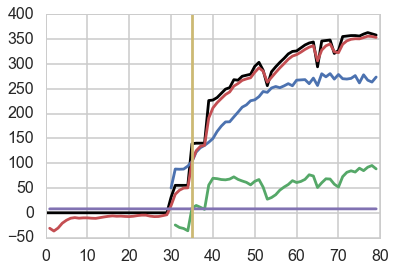

In [219]:
para = {}
                
para['n_shape'] = n_clusters
para['delta_init'] = float(400/3)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = [float(delta_shape) for _ in range(n_clusters)]
para['Q'] = float(100) # process error
para['R'] = float(100) # measurement error
para['shape'] = cluster_mean

data = all_seg_per_cluster[0][9]
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)

last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

for datum in data:
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)

plt.figure(figsize=(6,4))
plt.plot(data, 'k-')
plt.plot(np.arange(30,80), cluster_mean[0])
plt.plot( query_log_prob(delta_mean_list, time_since_last_cp_list, 30)[0] )
plt.plot( query_log_prob(delta_mean_list, time_since_last_cp_list, 0)[2] )
plt.plot(np.sqrt( query_log_prob(delta_var_list, time_since_last_cp_list, 0)[2] ) )
plt.plot([35,35],[-50,400])
print argmax_2d( log_prob_list[-1] )

6
6


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


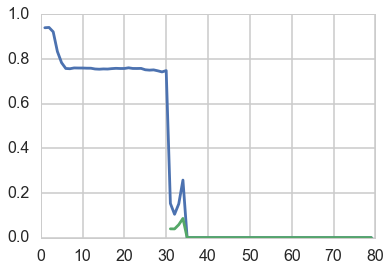

In [218]:
plt.figure(figsize=(6,4))
plt.plot( np.exp(query_log_prob(log_prob_list, time_since_last_cp_list, 0)[2] ) )
plt.plot( np.exp(query_log_prob(log_prob_list, time_since_last_cp_list, 30)[1] ) )

In [220]:
# ** the problem is that you have to use P(this is a cp| where is last cp) rather than P(this is a cp)

In [313]:
def set_prior_4(para):
    n_shape = para['n_shape']

    log_prob = [ [] for i_shape in range(n_shape) ]
    delta_mean = [ [] for i_shape in range(n_shape) ]
    delta_var = [ [] for i_shape in range(n_shape) ]
    time_since_last_cp = [ [] for i_shape in range(n_shape) ]
    
    return log_prob, delta_mean, delta_var, time_since_last_cp
    
def update_with_datum_4(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para):
    
    n_shape = para['n_shape']
    H = para['H']
    H_2_exp = 1-np.exp(H)
    delta_shape = para['delta_shape']
    Q = para['Q']
    R = para['R']
    shape = para['shape']
    
    # a function that return element within the shape or the last element of the list
    shape_helper = lambda i_shape, x: shape[i_shape][x] if x<len(shape[i_shape]) else shape[i_shape][-1]

    # step 1
    log_prob_grow = [ [] for _ in range(n_shape) ]
    time_since_last_cp_grow = [ [] for _ in range(n_shape)]

    # find the longest distance in time_since_last_cp
    if len(time_since_last_cp[0]) == 0:
        new_cp_prob = 1/float(n_shape)
        for i_shape in range(n_shape):
            log_prob_grow[i_shape] = [np.log(new_cp_prob)]
            time_since_last_cp_grow[i_shape] = [0]
    else:
        r_max = np.max( [t for x in time_since_last_cp for t in x] );
        
        # find probability of all shapes at r_max
        total_prob_since_last_cp = np.sum( [np.exp(t[-1]) for t in log_prob] )
        new_cp_prob = total_prob_since_last_cp * H_2_exp / n_shape
#         print new_cp_prob
        
        for i_shape in range(n_shape):
            log_prob_grow[i_shape] = [np.log(new_cp_prob)] + log_prob[i_shape][:-1] + [ log_prob[i_shape][-1]+H ]
            time_since_last_cp_grow[i_shape] = [0] + [x+1 for x in time_since_last_cp[i_shape]]
    
#     # step 1
#     log_prob_grow = [ [] for _ in range(n_shape) ]
#     time_since_last_cp_grow = [ [] for _ in range(n_shape) ]
#     for i_shape in range(n_shape):
#         log_prob_grow[i_shape] = [
#             np.log(H_2_exp*1./n_shape)
#         ] + [
#             x + H for x in log_prob[i_shape]
#         ]
#         time_since_last_cp_grow[i_shape] = [0] + [x+1 for x in time_since_last_cp[i_shape]]

    # step 2
    delta_mean_grow = [ [] for _ in range(n_shape) ]
    delta_var_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        delta_mean_grow[i_shape] = [
            shape_helper(i_shape, x)+y 
            for x, y in zip(time_since_last_cp_grow[i_shape], [last_datum]+delta_mean[i_shape])
        ]
        delta_var_grow[i_shape] = [
            para['delta_init'] 
        ] + [
            x+delta_shape[i_shape]+Q for x in delta_var[i_shape]
        ]
    
    # estimate probability
    p_predict = [ [ ] for i_shape in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        tmp = [ 0 for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            tmp[i_tau] = log_norm_pdf( datum, delta_mean_grow[i_shape][i_tau], delta_var_grow[i_shape][i_tau] + R )
        p_predict[i_shape] = tmp
    
    # Update step
    delta_mean_posterior = [ [] for _ in range(n_shape)]
    delta_var_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        delta_mean_tmp = [ [] for _ in range(n_tau) ]
        delta_var_tmp = [ [] for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            K = delta_var_grow[i_shape][i_tau] / (delta_var_grow[i_shape][i_tau]+R)
            offset = datum - delta_mean_grow[i_shape][i_tau]
            delta_mean_tmp[i_tau] = delta_mean_grow[i_shape][i_tau] + K * offset
            delta_var_tmp[i_tau] = (1-K) * delta_var_grow[i_shape][i_tau]
        delta_mean_posterior[i_shape] = delta_mean_tmp
        delta_var_posterior[i_shape] = delta_var_tmp
            
    # update prob
    log_prob_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x+y for x,y in zip(log_prob_grow[i_shape], p_predict[i_shape])]

    try:
        Z = sp.misc.logsumexp([x for t in log_prob_posterior for x in t]) # normalization
    except:
        print type(log_prob_posterior),log_prob_posterior
        Z = sp.misc.logsumexp(log_prob_posterior) # normalization
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x-Z for x in log_prob_posterior[i_shape]]
        
    # discount mean
    time_since_last_cp_posterior = time_since_last_cp_grow
    for i_shape in range(n_shape):
        delta_mean_posterior[i_shape] = [x-shape_helper(i_shape, y) for x, y in zip(delta_mean_posterior[i_shape], time_since_last_cp_posterior[i_shape])]

    return log_prob_posterior, delta_mean_posterior, delta_var_posterior, time_since_last_cp_posterior

# def argmax_2d(data):
#     c_min = data[0][0]
#     r = 0
#     c = 0
    
#     for c_r, l in enumerate(data):
#         for c_c, t in enumerate(l):
#             if t > c_min:
#                 r = c_r
#                 c = c_c
#                 c_min = t
#     return r, c
# #     data = np.array(data);
# #     return np.argmax(np.max(data, axis=1)), np.argmax(np.max(data, axis=0))

# def trim_prob(log_prob_posterior, 
#               delta_mean_posterior, 
#               delta_var_posterior,
#               time_since_last_cp_posterior,
#               protection_zone = 10,
#               thre = 0.3
#              ):
#     """
#     if the most-likely situation exceed the threshold, all the rest of data will be filtered unless 
#     in protection zone
#     """
        
#     # find the maximal
#     max_log_prob = np.max([x for t in log_prob_posterior for x in t ])
# #     print log_prob_posterior
# #     print type(log_prob_posterior), type(log_prob_posterior[0]), max_log_prob, np.array(log_prob_posterior)

#     # did not trigger trimming
#     if (max_log_prob < np.log(thre)):
#         return log_prob_posterior, delta_mean_posterior, delta_var_posterior, time_since_last_cp_posterior

#     # now find the location with max log prob
#     (i_shape_max, i_time_max) = argmax_2d(log_prob_posterior)

#     n_shapes = len(log_prob_posterior)
#     log_prob_posterior_new = [[] for _ in range(n_shapes)]
#     delta_mean_posterior_new = [[] for _ in range(n_shapes)]
#     delta_var_posterior_new = [[] for _ in range(n_shapes)]
#     time_since_last_cp_posterior_new = [[] for _ in range(n_shapes)]
    
#     for i_shape in range(n_shapes):
#         log_prob_posterior_new[i_shape] = [
#             t for i, t in enumerate(log_prob_posterior[i_shape])
#             if ( (time_since_last_cp_posterior[i_shape][i]<protection_zone) or ((i_shape==i_shape_max) and (i==i_time_max)) )
#         ]
#         delta_mean_posterior_new[i_shape] = [
#             t for i, t in enumerate(delta_mean_posterior[i_shape])
#             if ( (time_since_last_cp_posterior[i_shape][i]<protection_zone) or ((i_shape==i_shape_max) and (i==i_time_max)) )
#         ]
#         delta_var_posterior_new[i_shape] = [
#             t for i, t in enumerate(delta_var_posterior[i_shape])
#             if ( (time_since_last_cp_posterior[i_shape][i]<protection_zone) or ((i_shape==i_shape_max) and (i==i_time_max)) )
#         ]
#         time_since_last_cp_posterior_new[i_shape] = [
#             t for i, t in enumerate(time_since_last_cp_posterior[i_shape])
#             if ( (time_since_last_cp_posterior[i_shape][i]<protection_zone) or ((i_shape==i_shape_max) and (i==i_time_max)) )
#         ]

#     return log_prob_posterior_new, delta_mean_posterior_new, delta_var_posterior_new, time_since_last_cp_posterior_new

6
6
6
(0, 0)


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


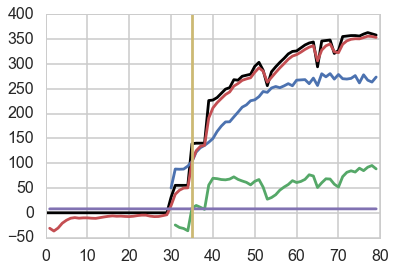

In [311]:
para = {}
                
para['n_shape'] = n_clusters
para['delta_init'] = float(400/3)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = [float(delta_shape) for _ in range(n_clusters)]
para['Q'] = float(100) # process error
para['R'] = float(100) # measurement error
para['shape'] = cluster_mean

data = all_seg_per_cluster[0][9]
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_4(para)

last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

for datum in data:
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_4(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)

plt.figure(figsize=(6,4))
plt.plot(data, 'k-')
plt.plot(np.arange(30,80), cluster_mean[0])
plt.plot( query_log_prob(delta_mean_list, time_since_last_cp_list, 30)[0] )
plt.plot( query_log_prob(delta_mean_list, time_since_last_cp_list, 0)[2] )
plt.plot(np.sqrt( query_log_prob(delta_var_list, time_since_last_cp_list, 0)[2] ) )
plt.plot([35,35],[-50,400])
print argmax_2d( log_prob_list[-1] )

6


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


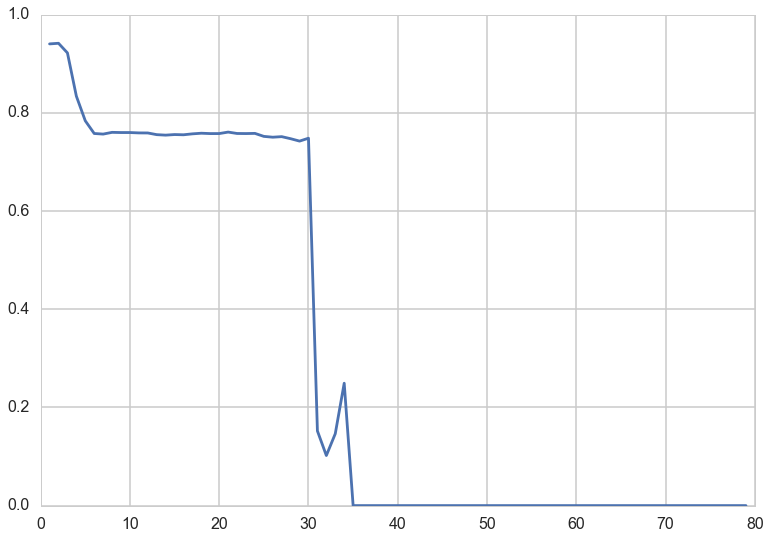

In [251]:
plt.plot( np.exp( query_log_prob(log_prob_list, time_since_last_cp_list, 0)[2] ) )

In [242]:
for x,y in enumerate(log_prob_list[79][0]):
    print x,np.exp(y)

0 8.36755448537e-21
1 2.81893333146e-27
2 1.0077578319e-26
3 1.96352969696e-25
4 2.22500818453e-26
5 2.78137760066e-27
6 5.56541366085e-28
7 6.34289789943e-28
8 9.95181936144e-21
9 5.29895871994e-21
10 3.55139741862e-33
11 1.12953025389e-33
12 9.14647492531e-30
13 1.10853428841e-17
14 3.24340444473e-31
15 4.42119576107e-36
16 6.90442090846e-32
17 8.17470945372e-28
18 1.08881656211e-25
19 4.15185241338e-26
20 7.06671399997e-29
21 1.38694794914e-27
22 5.68373464436e-26
23 9.11669583468e-24
24 1.1069914196e-21
25 4.26437496463e-20
26 4.34325507752e-31
27 1.12490460135e-38
28 2.21446844489e-29
29 2.9282944882e-22
30 5.25062247019e-23
31 2.40046411026e-27
32 6.77443435123e-27
33 8.98548044223e-28
34 5.87519344525e-23
35 2.85664378019e-22
36 1.50332210225e-24
37 1.36478679123e-23
38 1.01549116437e-24
39 5.18228709032e-24
40 0.000552812171757
41 4.24484338188e-08
42 4.99255126078e-20
43 4.51147637921e-20
44 0.0354187887683
45 0.0107998420801
46 1.50255927417e-14
47 4.3882080031e-17
48 3.68726

In [243]:
for x,y in enumerate(log_prob_list[79][1]):
    print x,np.exp(y)

0 1.41943604575e-22
1 3.79655512381e-27
2 1.64298578849e-26
3 1.68246213897e-25
4 1.65269245061e-26
5 1.49684853531e-27
6 1.03042752794e-27
7 1.2651294989e-27
8 3.95862015865e-20
9 1.03313721612e-21
10 2.71332221002e-33
11 9.0414713584e-32
12 9.11257000185e-29
13 1.75804879547e-15
14 3.96864192827e-33
15 2.55302857111e-33
16 4.81811890611e-29
17 2.49858444551e-26
18 4.21475340703e-24
19 1.42779943621e-26
20 9.30232486959e-26
21 2.41180031776e-25
22 6.60390166298e-24
23 3.22870859866e-23
24 6.17641887233e-21
25 1.07300000636e-18
26 5.72444129674e-30
27 8.06810201375e-36
28 4.79130892654e-29
29 6.80579624018e-22
30 6.09146414177e-23
31 1.9918283256e-25
32 1.1628576047e-25
33 6.80661352453e-27
34 3.23401950543e-23
35 8.20635575079e-23
36 5.91664402261e-22
37 6.87477899132e-22
38 5.13538657358e-25
39 5.63685460728e-23
40 0.00671168546057
41 1.07328397634e-09
42 1.39411861002e-19
43 1.97749289864e-19
44 0.372939817905
45 0.00090892686931
46 6.82134015222e-14
47 1.34969668057e-16
48 3.494523

In [240]:
def get_performance_4(para, data, n_padding):
    log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_4(para)

    last_datum = 0

    for datum in data:
        log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_4(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
        last_datum = datum

    result = []
    for pos in range(n_padding, n_padding+2):
        result.append( np.sum(np.exp([t[len(data)-pos] for t in log_prob])) )

    return np.max(result)

In [248]:
# %%time

for Q in [20, 50, 200, 800]:
    for R in [25, 50, 100, 400]:
        for delta_init in [25]:
            delta_init = R / float(3)
            for delta_shape in [10]:

                para = {}
                
                para['n_shape'] = n_clusters
                para['delta_init'] = float(delta_init)
                para['H'] = np.log(1-1./(15*4)) # 15 min per cp
                para['delta_shape'] = [float(delta_shape) for _ in range(n_clusters)]
                para['Q'] = float(Q) # process error
                para['R'] = float(R) # measurement error
                para['shape'] = cluster_mean
                
                final_prob = []
                
                n_padding = 30
                
                for i_shape in [0]:
                    n_curve = len(all_seg_per_cluster[i_shape])
                    for i_curve in range(n_curve):
                        data = all_seg_per_cluster[i_shape][i_curve]
                        data = add_padding_zero(data, n_padding)
                        _, data = rel_change_filter_0819_3(range(len(data)), data)
                        
                        final_prob.append( get_performance_4(para, data, n_padding) )
                        
                success_rate = np.sum([1 for t in final_prob if t > .5])/float(len(final_prob))
                print Q, R, delta_init, delta_shape, success_rate


20 25 8.33333333333 10 0.6875
20 50 16.6666666667 10 0.75
20 100 33.3333333333 10 0.6875
20 400 133.333333333 10 0.6875
50 25 8.33333333333 10 0.625
50 50 16.6666666667 10 0.6875
50 100 33.3333333333 10 0.71875
50 400 133.333333333 10 0.6875
200 25 8.33333333333 10 0.53125
200 50 16.6666666667 10 0.625
200 100 33.3333333333 10 0.65625
200 400 133.333333333 10 0.6875
800 25 8.33333333333 10 0.0625
800 50 16.6666666667 10 0.09375
800 100 33.3333333333 10 0.1875
800 400 133.333333333 10 0.375


In [274]:
# %%time

for Q in [10, 20]:
    for R in [25, 50, 100, 400]:
        for delta_init in [25]:
            delta_init = R / float(3)
            for delta_shape in [10]:

                para = {}
                
                para['n_shape'] = n_clusters
                para['delta_init'] = float(delta_init)
                para['H'] = np.log(1-1./(15*4)) # 15 min per cp
                para['delta_shape'] = [float(delta_shape) for _ in range(n_clusters)]
                para['Q'] = float(Q) # process error
                para['R'] = float(R) # measurement error
                para['shape'] = cluster_mean
                
                final_prob = []
                
                n_padding = 30
                
                for i_shape in [0]:
                    n_curve = len(all_seg_per_cluster[i_shape])
                    for i_curve in range(n_curve):
                        data = all_seg_per_cluster[i_shape][i_curve]
                        data = add_padding_zero(data, n_padding)
                        _, data = rel_change_filter_0819_3(range(len(data)), data)
                        
                        final_prob.append( get_performance_4(para, data, n_padding) )
                        
                success_rate = np.sum([1 for t in final_prob if t > .5])/float(len(final_prob))
                print Q, R, delta_init, delta_shape, success_rate


10 25 8.33333333333 10 0.6875
10 50 16.6666666667 10 0.75
10 100 33.3333333333 10 0.6875
10 400 133.333333333 10 0.75
20 25 8.33333333333 10 0.6875
20 50 16.6666666667 10 0.75
20 100 33.3333333333 10 0.6875
20 400 133.333333333 10 0.6875


6
6
6
(0, 49)


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


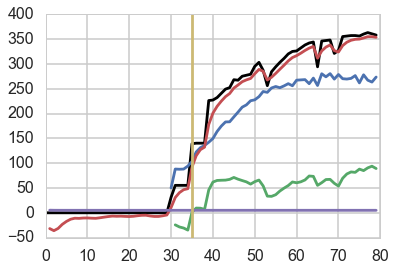

In [278]:
para = {}
                
para['n_shape'] = n_clusters
para['delta_init'] = float(400/3)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = [float(50/3) for _ in range(n_clusters)]
para['Q'] = float(10) # process error
para['R'] = float(50) # measurement error
para['shape'] = cluster_mean

data = all_seg_per_cluster[0][9]
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_4(para)

last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

counter = 0

for datum in data:
#     print counter
    counter += 1
    
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_4(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)

plt.figure(figsize=(6,4))
plt.plot(data, 'k-')
plt.plot(np.arange(30,80), cluster_mean[0])
plt.plot( query_log_prob(delta_mean_list, time_since_last_cp_list, 30)[0] )
plt.plot( query_log_prob(delta_mean_list, time_since_last_cp_list, 0)[2] )
plt.plot(np.sqrt( query_log_prob(delta_var_list, time_since_last_cp_list, 0)[2] ) )
plt.plot([35,35],[-50,400])
print argmax_2d( log_prob_list[-1] )

6
6
6
6
6
6


/Users/bohua/anaconda/envs/working/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


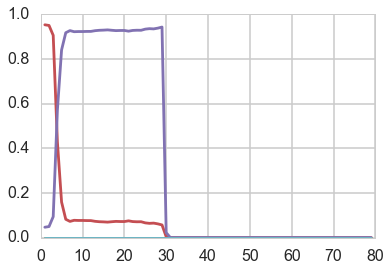

In [280]:
plt.figure(figsize=(6,4))
for i in range(6):
    plt.plot( np.exp( query_log_prob(log_prob_list, time_since_last_cp_list, 0)[i] ) )
# plt.plot( np.exp( query_log_prob(log_prob_list, time_since_last_cp_list, 31)[0] ) )

In [269]:
log_prob_list[35][0][35]

-135.5415961565472

In [291]:
%%time

para = {}
                
para['n_shape'] = n_clusters
para['delta_init'] = float(400/3)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = [float(50/3) for _ in range(n_clusters)]
para['Q'] = float(10) # process error
para['R'] = float(50) # measurement error
para['shape'] = cluster_mean

data = all_seg_per_cluster[0][9]
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_4(para)

last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

counter = 0
disappointment_counter = 0

for datum in data:
#     print counter
    counter += 1
    
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_4(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    print counter, conf_last_cp(log_prob)
    if conf_last_cp(log_prob) < 0.1:
        disappointment_counter += 1
    else:
        disappointment_counter = 0
    
    if disappointment_counter == 4:
        print "cp graudate!"
        log_prob, delta_mean, delta_var, time_since_last_cp = cp_graduate(
            log_prob, 
            delta_mean, 
            delta_var, 
            time_since_last_cp, 
            4
        )
    else:
        pass
    
    
    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)


1 1.0
2 0.999867435937
3 0.999957749771
4 0.99995081496
5 0.999835140856
6 0.999939998427
7 0.999961929199
8 0.999969854479
9 0.99997082126
10 0.999972356164
11 0.999972529149
12 0.999972362699
13 0.999972117341
14 0.999971773558
15 0.999970477098
16 0.999969818972
17 0.999970245617
18 0.999969605859
19 0.999969496474
20 0.999969888036
21 0.999969643782
22 0.999967778707
23 0.999968732852
24 0.999968201671
25 0.999968214352
26 0.99996780119
27 0.999967619655
28 0.99996683814
29 0.999966597686
30 0.999965958421
31 0.0259360272741
32 2.71207726427e-07
33 1.46175156032e-08
34 3.80218688427e-08
cp graudate!
35 0.999964257759
36 8.01724745469e-12
37 9.42637157325e-13
38 1.99531414835e-12
39 3.5567497758e-12
cp graudate!
40 9.72336392937e-21
41 2.66214389219e-21
42 2.59512099728e-21
43 1.73844439875e-21
44 1.78942140469e-21
45 4.46502973341e-21
46 4.48223261959e-21
47 3.97223244642e-21
48 3.11586155802e-21
49 4.19904699782e-21
50 2.10038914592e-21
51 2.49653136495e-21
52 4.12857205495e-21
53

In [33]:
def conf_last_cp(log_prob):
    return np.sum([np.exp(t[-1]) for t in log_prob])

In [34]:
def cp_graduate(log_prob, delta_mean, delta_var, time_since_last_cp, disp_time):
    for i_shape in range(len(time_since_last_cp)):
        log_prob[i_shape] = [y for x,y in enumerate(log_prob[i_shape]) if time_since_last_cp[i_shape][x]==disp_time]
        delta_mean[i_shape] = [y for x,y in enumerate(delta_mean[i_shape]) if time_since_last_cp[i_shape][x]==disp_time]
        delta_var[i_shape] = [y for x,y in enumerate(delta_var[i_shape]) if time_since_last_cp[i_shape][x]==disp_time]
        time_since_last_cp[i_shape] = [y for x,y in enumerate(time_since_last_cp[i_shape]) if time_since_last_cp[i_shape][x]==disp_time]
        
    # normalize
    z = -np.log(np.sum([np.exp(t[0]) for t in log_prob]))
    log_prob = [[t[0]+z] for t in log_prob]
    
    return log_prob, delta_mean, delta_var, time_since_last_cp

In [35]:
def cp_fail(log_prob, delta_mean, delta_var, time_since_last_cp, disp_time):
    for i_shape in range(len(time_since_last_cp)):
        log_prob[i_shape] = [y for x,y in enumerate(log_prob[i_shape]) if (time_since_last_cp[i_shape][x]<disp_time or (x == (len(log_prob[i_shape])-1) ))]
        delta_mean[i_shape] = [y for x,y in enumerate(delta_mean[i_shape]) if (time_since_last_cp[i_shape][x]<disp_time or (x == (len(log_prob[i_shape])-1)))]
        delta_var[i_shape] = [y for x,y in enumerate(delta_var[i_shape]) if (time_since_last_cp[i_shape][x]<disp_time or (x == (len(log_prob[i_shape])-1)))]
        time_since_last_cp[i_shape] = [y for x,y in enumerate(time_since_last_cp[i_shape]) if (time_since_last_cp[i_shape][x]<disp_time or (x == (len(log_prob[i_shape])-1)))]
        
    # normalize
#     z = -np.log(np.sum( [np.exp(x) for t in log_prob for x in t] ))
#     log_prob = [[x+z for x in t] for t in log_prob]
#     z = -np.log(np.sum([np.exp(t[0]) for t in log_prob]))
#     log_prob = [[t[0]+z] for t in log_prob]
    
    return log_prob, delta_mean, delta_var, time_since_last_cp

In [328]:
para = {}
                
para['n_shape'] = n_clusters
para['delta_init'] = float(400/3)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = [float(50/3) for _ in range(n_clusters)]
para['Q'] = float(10) # process error
para['R'] = float(50) # measurement error
para['shape'] = cluster_mean

data = all_seg_per_cluster[0][9]
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_4(para)

last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

counter = 0
disappointment_counter = 0

for datum in data:
#     print counter
    counter += 1
    
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_4(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    print counter, conf_last_cp(log_prob)
    if conf_last_cp(log_prob) < 0.1:
        print "disp"
        disappointment_counter += 1
        if disappointment_counter == 4:
            print "cp graudate!"
            log_prob, delta_mean, delta_var, time_since_last_cp = cp_graduate(
                log_prob, 
                delta_mean, 
                delta_var, 
                time_since_last_cp, 
                4
            )
    else:
        disappointment_counter = 0
        if disappointment_counter==0:
            print "cp fail"
            log_prob, delta_mean, delta_var, time_since_last_cp = cp_fail(
                log_prob, 
                delta_mean, 
                delta_var, 
                time_since_last_cp, 
                4
            )
    
    
    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)


1 1.0
cp fail
2 0.999867435937
cp fail
3 0.999957749771
cp fail
4 0.99995081496
cp fail
5 0.999835140856
cp fail
6 0.999939998427
cp fail
7 0.99997399934
cp fail
8 0.999983174113
cp fail
9 0.999986522007
cp fail
10 0.999987195937
cp fail
11 0.999987296359
cp fail
12 0.999987321711
cp fail
13 0.999987328108
cp fail
14 0.999987329722
cp fail
15 0.999987330129
cp fail
16 0.999987330232
cp fail
17 0.999987330258
cp fail
18 0.999987330264
cp fail
19 0.999987330266
cp fail
20 0.999987330266
cp fail
21 0.999987330267
cp fail
22 0.999987330267
cp fail
23 0.999987330267
cp fail
24 0.999987330267
cp fail
25 0.999987330267
cp fail
26 0.999987330267
cp fail
27 0.999987330267
cp fail
28 0.999987330267
cp fail
29 0.999987330267
cp fail
30 0.999987330267
cp fail
31 0.0204088005911
disp
32 6.35393319521e-08
disp
33 1.27027934783e-09
disp
34 4.98151581212e-09
disp
cp graudate!
35 0.999964257759
cp fail
36 8.01724745469e-12
disp
37 9.42637157325e-13
disp
38 1.99531414835e-12
disp
39 3.5567497758e-12
dis

In [329]:
log_prob_list[35]

[[-2.7750056019916034, -18.356080119630853, -25.54943221551374],
 [-0.064385515292622486, -30.980680227031755, -37.531971900762528],
 [-11.812955297438997, -41.030746466892857, -89.73030568293143],
 [-81.422284198228141, -89.824766210426077, -94.604381680083861],
 [-175.20783664182929, -178.29363151321564, -172.89896284329367],
 [-247.0470759821155, -231.29065100235866, -225.39940028150139]]

In [22]:
def set_prior_5(para):
    n_shape = para['n_shape']

    log_prob = [ [] for i_shape in range(n_shape) ]
    delta_mean = [ [] for i_shape in range(n_shape) ]
    delta_var = [ [] for i_shape in range(n_shape) ]
    time_since_last_cp = [ [] for i_shape in range(n_shape) ]
    
    return log_prob, delta_mean, delta_var, time_since_last_cp
    
def update_with_datum_5(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para):
    
    n_shape = para['n_shape']
    H = para['H']
    H_2_exp = 1-np.exp(H)
    delta_shape = para['delta_shape']
    Q = para['Q']
    R = para['R']
    shape = para['shape']
    
    # a function that return element within the shape or the last element of the list
    shape_helper = lambda i_shape, x: shape[i_shape][x] if x<len(shape[i_shape]) else shape[i_shape][-1]

    # step 1
    log_prob_grow = [ [] for _ in range(n_shape) ]
    time_since_last_cp_grow = [ [] for _ in range(n_shape)]

    # find the longest distance in time_since_last_cp
    if len(time_since_last_cp[0]) == 0:
        new_cp_prob = 1/float(n_shape)
        for i_shape in range(n_shape):
            log_prob_grow[i_shape] = [np.log(new_cp_prob)]
            time_since_last_cp_grow[i_shape] = [0]
    else:
        r_max = np.max( [t for x in time_since_last_cp for t in x] );
        
        # find probability of all shapes at r_max
        total_prob_since_last_cp = np.sum( [np.exp(t[-1]) for t in log_prob] )
        new_cp_prob = total_prob_since_last_cp * H_2_exp / n_shape

        if r_max < 10:
            new_cp_prob = np.exp(-50)
        
        for i_shape in range(n_shape):
            log_prob_grow[i_shape] = [np.log(new_cp_prob)] + log_prob[i_shape][:-1] + [ log_prob[i_shape][-1]+H ]
            time_since_last_cp_grow[i_shape] = [0] + [x+1 for x in time_since_last_cp[i_shape]]
    
    # step 2
    delta_mean_grow = [ [] for _ in range(n_shape) ]
    delta_var_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        delta_mean_grow[i_shape] = [
            shape_helper(i_shape, x)+y 
            for x, y in zip(time_since_last_cp_grow[i_shape], [last_datum]+delta_mean[i_shape])
        ]
        delta_var_grow[i_shape] = [
            para['delta_init'] 
        ] + [
            x+delta_shape[i_shape]+Q for x in delta_var[i_shape]
        ]
    
    # estimate probability
    p_predict = [ [ ] for i_shape in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        tmp = [ 0 for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            tmp[i_tau] = log_norm_pdf( datum, delta_mean_grow[i_shape][i_tau], delta_var_grow[i_shape][i_tau] + R )
        p_predict[i_shape] = tmp
    
    # Update step
    delta_mean_posterior = [ [] for _ in range(n_shape)]
    delta_var_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        delta_mean_tmp = [ [] for _ in range(n_tau) ]
        delta_var_tmp = [ [] for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            K = delta_var_grow[i_shape][i_tau] / (delta_var_grow[i_shape][i_tau]+R)
            offset = datum - delta_mean_grow[i_shape][i_tau]
            delta_mean_tmp[i_tau] = delta_mean_grow[i_shape][i_tau] + K * offset
            delta_var_tmp[i_tau] = (1-K) * delta_var_grow[i_shape][i_tau]
        delta_mean_posterior[i_shape] = delta_mean_tmp
        delta_var_posterior[i_shape] = delta_var_tmp
            
    # update prob
    log_prob_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x+y for x,y in zip(log_prob_grow[i_shape], p_predict[i_shape])]

    try:
        Z = sp.misc.logsumexp([x for t in log_prob_posterior for x in t]) # normalization
    except:
        print type(log_prob_posterior),log_prob_posterior
        Z = sp.misc.logsumexp(log_prob_posterior) # normalization
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x-Z for x in log_prob_posterior[i_shape]]
        
    # discount mean
    time_since_last_cp_posterior = time_since_last_cp_grow
    for i_shape in range(n_shape):
        delta_mean_posterior[i_shape] = [x-shape_helper(i_shape, y) for x, y in zip(delta_mean_posterior[i_shape], time_since_last_cp_posterior[i_shape])]

    return log_prob_posterior, delta_mean_posterior, delta_var_posterior, time_since_last_cp_posterior


In [37]:
para = {}
                
para['n_shape'] = n_clusters
para['delta_init'] = float(400/3)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = [float(50/3) for _ in range(n_clusters)]
para['Q'] = float(10) # process error
para['R'] = float(200) # measurement error
para['shape'] = cluster_mean

n_padding = 30

data = all_seg_per_cluster[0][9]
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_5(para)

last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

counter = 0
disappointment_counter = 0

disappointment_counter_thre = 4
flag = False

for datum in data:
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_5(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    if conf_last_cp(log_prob) < 0.1:
        disappointment_counter += 1
        if disappointment_counter == disappointment_counter_thre:
            print counter, "cp graudate!"
            log_prob, delta_mean, delta_var, time_since_last_cp = cp_graduate(
                log_prob, 
                delta_mean, 
                delta_var, 
                time_since_last_cp, 
                disappointment_counter_thre
            )
#             print log_prob
            disappointment_counter = 0
            flag = True
    else:
        disappointment_counter = 0
        
        for i_shape in range(n_clusters):
            log_prob[i_shape] = [y for x,y in enumerate(log_prob[i_shape]) if (x==(len(log_prob[i_shape])-1) or time_since_last_cp[i_shape][x]<4)]
            delta_mean[i_shape] = [y for x,y in enumerate(delta_mean[i_shape]) if (x==(len(log_prob[i_shape])-1) or time_since_last_cp[i_shape][x]<4)]
            delta_var[i_shape] = [y for x,y in enumerate(delta_var[i_shape]) if (x==(len(log_prob[i_shape])-1) or time_since_last_cp[i_shape][x]<4)]
            time_since_last_cp[i_shape] = [y for x,y in enumerate(time_since_last_cp[i_shape]) if (x==(len(log_prob[i_shape])-1) or time_since_last_cp[i_shape][x]<4)]
        
#         print np.sum([np.exp(t) for x in log_prob for t in x])
        
#         if disappointment_counter==0:
#             print log_prob
#             log_prob, delta_mean, delta_var, time_since_last_cp = cp_fail(
#                 log_prob, 
#                 delta_mean, 
#                 delta_var, 
#                 time_since_last_cp, 
#                 10
#             )
#             print log_prob

#     print len(time_since_last_cp[0]), len(log_prob[0])
    counter += 1
    
    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)


40 cp graudate!


In [59]:
def is_happy(prob, prob_thre=.3, len_protect = 5):
    last_cp_prob = np.sum( [np.exp(t[-1]) for t in prob] )
    return (last_cp_prob>prob_thre) or ( len(prob)<len_protect )

In [60]:
# log_prob, delta_mean, delta_var, time_since_last_cp

def trim_5(var, time_since_last_cp, time_thre=5):
    new_var = [[] for _ in range(len(var))]
    for i in range(len(var)):
        new_var[i] = [
            val 
            for pos, val in enumerate(var[i]) 
            if ((time_since_last_cp[i][pos]<time_thre) or (pos+1==len(var[i]) )) 
        ]
    return new_var

In [65]:
%%time

para = {}
                
para['n_shape'] = n_clusters
para['delta_init'] = float(400/3)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = [float(50/3) for _ in range(n_clusters)]
para['Q'] = float(10) # process error
para['R'] = float(200) # measurement error
para['shape'] = cluster_mean

n_padding = 30

data = all_seg_per_cluster[0][9]
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

current_data_pos = 0
last_datum = 0

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_5(para)
last_cp = 0

cp_list = [last_cp]

unhappy_count = 0
unhappy_count_thre = 5

while (current_data_pos<len(data)):
    datum = data[current_data_pos]
    
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_5(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    leader_prob = np.sum( [np.exp(t[-1]) for t in log_prob] )
    leader_shape = np.argmax( [t[-1] for t in log_prob] )
    
    if is_happy(log_prob):
        current_data_pos += 1
        unhappy_count = 0 # reset counter
        
        log_prob = trim_5(log_prob, time_since_last_cp)
        delta_mean = trim_5(delta_mean, time_since_last_cp)
        delta_var = trim_5(delta_var, time_since_last_cp)
        time_since_last_cp = trim_5(time_since_last_cp, time_since_last_cp)
        
        print "at pos: %d, datum:%.0f, happy, leader shape: %d, prob of last cp %.1f%%" %(current_data_pos-1, datum, leader_shape, 100*leader_prob)
    else:
        unhappy_count += 1
        if (unhappy_count == unhappy_count_thre):
            current_data_pos = current_data_pos - unhappy_count_thre
            last_datum = np.mean( data[(current_data_pos-3):current_data_pos] )
            
            log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_5(para)
            last_cp = current_data_pos
            
            cp_list.append(last_cp)
            
            print "at pos: %d, datum:%.0f, unhappy %d times, give up, back to pos %d" %(current_data_pos+unhappy_count_thre, datum, unhappy_count, current_data_pos)
        else:
            current_data_pos += 1
            print "at pos: %d, datum:%.0f, unhappy %d times, prob of last cp %.1f%%" %(current_data_pos, datum, unhappy_count, 100*leader_prob)

print 'all cp(s): ', cp_list

at pos: 0, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 1, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 2, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 3, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 4, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 5, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 6, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 7, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 8, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 9, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 10, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 11, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 12, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 13, datum:0, happy, leader shape: 2, prob of last cp 100.0%
at pos: 14, datum:0, happy, leader shape: 2, prob of last 

In [68]:
def disaggregate(data, para, 
                 unhappy_count_thre = 5):

    current_data_pos = 0
    last_datum = 0

    log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_5(para)
    last_cp = 0

    cp_list = [last_cp]

    unhappy_count = 0
    
    while (current_data_pos<len(data)):
        datum = data[current_data_pos]

        log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_5(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
        leader_prob = np.sum( [np.exp(t[-1]) for t in log_prob] )
        leader_shape = np.argmax( [t[-1] for t in log_prob] )

        if is_happy(log_prob):
            current_data_pos += 1
            unhappy_count = 0 # reset counter

            log_prob = trim_5(log_prob, time_since_last_cp)
            delta_mean = trim_5(delta_mean, time_since_last_cp)
            delta_var = trim_5(delta_var, time_since_last_cp)
            time_since_last_cp = trim_5(time_since_last_cp, time_since_last_cp)

#             print "at pos: %d, datum:%.0f, happy, leader shape: %d, prob of last cp %.1f%%" %(current_data_pos-1, datum, leader_shape, 100*leader_prob)
        else:
            unhappy_count += 1
            if (unhappy_count == unhappy_count_thre):
                current_data_pos = current_data_pos - unhappy_count_thre
                last_datum = np.mean( data[(current_data_pos-3):current_data_pos] )

                log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_5(para)
                last_cp = current_data_pos

                cp_list.append(last_cp)

#                 print "at pos: %d, datum:%.0f, unhappy %d times, give up, back to pos %d" %(current_data_pos+unhappy_count_thre, datum, unhappy_count, current_data_pos)
            else:
                current_data_pos += 1
#                 print "at pos: %d, datum:%.0f, unhappy %d times, prob of last cp %.1f%%" %(current_data_pos, datum, unhappy_count, 100*leader_prob)
    return cp_list

In [87]:
%%time

para = {}
                
para['n_shape'] = n_clusters-1
para['delta_init'] = float(400/3)
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = [float(50/3) for _ in range(n_clusters)]
para['Q'] = float(10) # process error
para['R'] = float(200) # measurement error
para['shape'] = [cluster_mean[i] for i in [0,1,3,4,5]]

n_padding = 30

data = all_seg_per_cluster[0][9]
data = add_padding_zero(data, n_padding)
_, data = rel_change_filter_0819_3(range(len(data)), data)

cp_list = disaggregate(data, para)

print 'all cp(s): ', cp_list

all cp(s):  [0, 30]
CPU times: user 64.8 ms, sys: 2.8 ms, total: 67.6 ms
Wall time: 67.1 ms


In [88]:
from os import path
import datetime

def read_dat_0819(date, h_start, h_end, folder_path):
    t = []
    dat = []
    start_time = None
    for h in range(h_start, h_end):
        try:
            file_name = '%d-%d-%d.csv' % (date.month, date.day, h)
            file_path = path.join(folder_path, file_name)
            data_pd = pd.read_csv(file_path, names=['time', 'data'])
            time_tmp = pd.to_datetime(data_pd.time,infer_datetime_format=True)
            if not start_time:
                start_time = time_tmp[0]
            tmp = [(x - start_time).seconds/3600. for x in time_tmp]
            t.extend(tmp)
            dat.extend( [x/3 for x in data_pd.data] )
        except Exception as inst:
            print type(inst), inst.args, inst     # the exception instance
            print '%s failed' % file_path
    return t, dat

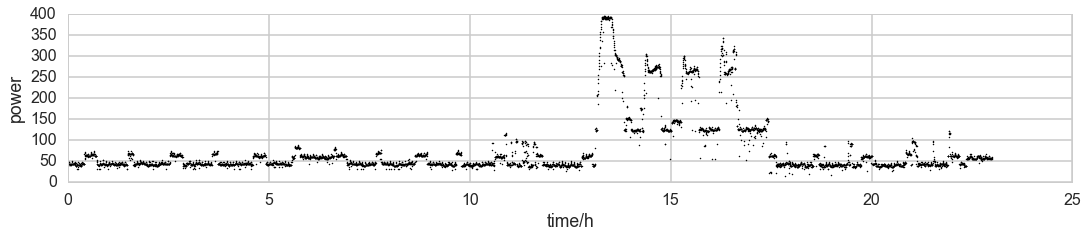

In [89]:
# example of read_dat_0819

# t, dat = read_dat_0819(datetime.date(2016,4,1), 0, 23, '../new_data/IHG')
t, data = read_dat_0819(datetime.date(2016,4,1), 0, 23, '../new_data/IHG')

plt.figure(figsize=[18,3])
plt.plot(t, data, 'k.', markersize=3)
plt.xlabel('time/h')
plt.ylabel('power')

In [97]:
%%time

t, data = read_dat_0819(datetime.date(2016,4,1), 0, 23, '../new_data/IHG')
_, data = rel_change_filter_0819_3(range(len(data)), data)

cp_list = disaggregate(data, para)

print 'all cp(s): ', cp_list

all cp(s):  [0, 2606, 2616, 2646, 2683, 2709, 3149, 3321, 3418, 3437, 3542, 3662, 3722, 3767, 3888, 3991]
CPU times: user 5.17 s, sys: 79.9 ms, total: 5.25 s
Wall time: 5.24 s


(10, 15)

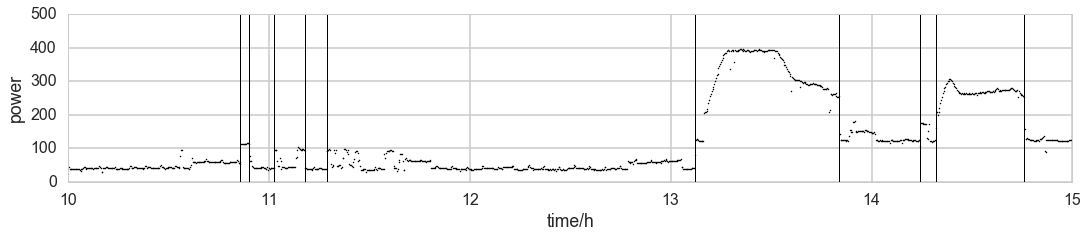

In [99]:
plt.figure(figsize=[18,3])
plt.plot(t, data, 'k.', markersize=3)
for cp in cp_list:
    plt.plot([t[cp],t[cp]], [0,500], 'k-', linewidth=1)

plt.xlabel('time/h')
plt.ylabel('power')

plt.xlim([10,15])

In [108]:
%%time

t, data = read_dat_0819(datetime.date(2016,4,2), 0, 23, '../new_data/IHG')
_, data = rel_change_filter_0819_3(range(len(data)), data)

cp_list = disaggregate(data, para)

print 'all cp(s): ', cp_list

all cp(s):  [0, 3244, 3431, 3492, 3498, 3550, 3654, 3786, 3886, 3944, 4021, 4030, 4121, 4263, 4289, 4330, 4362, 4412, 4439, 4495, 4521, 4576, 4656, 4683, 4727, 4741, 4767, 4816, 4846, 4866, 4873, 4904, 4929, 4957, 4985, 5008, 5012, 5033, 5052, 5062, 5199, 5207, 5329, 5342, 5375]
CPU times: user 5.49 s, sys: 96.4 ms, total: 5.59 s
Wall time: 5.64 s


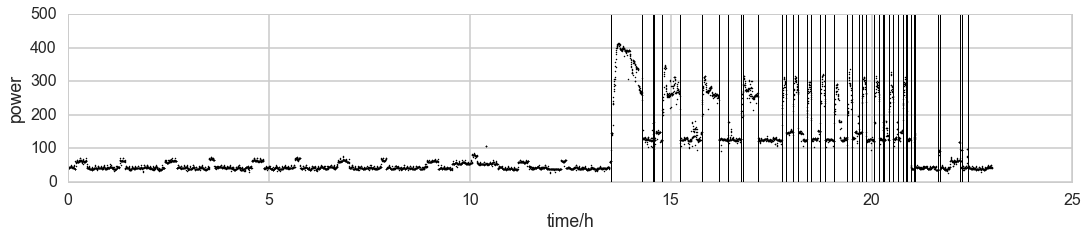

In [112]:
plt.figure(figsize=[18,3])
plt.plot(t, data, 'k.', markersize=3)
for cp in cp_list:
    plt.plot([t[cp],t[cp]], [0,500], 'k-', linewidth=1)

plt.xlabel('time/h')
plt.ylabel('power')

# plt.xlim([18,19])

In [150]:
def set_prior_5(para):
    n_shape = para['n_shape']

    log_prob = [ [] for i_shape in range(n_shape) ]
    delta_mean = [ [] for i_shape in range(n_shape) ]
    delta_var = [ [] for i_shape in range(n_shape) ]
    time_since_last_cp = [ [] for i_shape in range(n_shape) ]
    
    return log_prob, delta_mean, delta_var, time_since_last_cp
    
def update_with_datum_5(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para):
    
    n_shape = para['n_shape']
    H = para['H']
    H_2_exp = 1-np.exp(H)
    delta_shape = para['delta_shape']
    Q = para['Q']
    R = para['R']
    shape = para['shape']
    
    # a function that return element within the shape or the last element of the list
    shape_helper = lambda i_shape, x: shape[i_shape][x] if x<len(shape[i_shape]) else shape[i_shape][-1]

    # step 1
    log_prob_grow = [ [] for _ in range(n_shape) ]
    time_since_last_cp_grow = [ [] for _ in range(n_shape)]

    # find the longest distance in time_since_last_cp
    if len(time_since_last_cp[0]) == 0:
        new_cp_prob = 1/float(n_shape)
        for i_shape in range(n_shape):
            log_prob_grow[i_shape] = [np.log(new_cp_prob)]
            time_since_last_cp_grow[i_shape] = [0]
    else:
        r_max = np.max( [t for x in time_since_last_cp for t in x] );
        
        # find probability of all shapes at r_max
        total_prob_since_last_cp = np.sum( [np.exp(t[-1]) for t in log_prob] )
        new_cp_prob = total_prob_since_last_cp * H_2_exp / n_shape

        if r_max < 5:
            new_cp_prob = np.exp(-50)
        
        for i_shape in range(n_shape):
            log_prob_grow[i_shape] = [np.log(new_cp_prob)] + log_prob[i_shape][:-1] + [ log_prob[i_shape][-1]+H ]
            time_since_last_cp_grow[i_shape] = [0] + [x+1 for x in time_since_last_cp[i_shape]]
    
    # step 2
    delta_mean_grow = [ [] for _ in range(n_shape) ]
    delta_var_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        delta_mean_grow[i_shape] = [
            shape_helper(i_shape, x)+y 
            for x, y in zip(time_since_last_cp_grow[i_shape], [last_datum]+delta_mean[i_shape])
        ]
        delta_var_grow[i_shape] = [
            para['delta_init'] 
        ] + [
            x+delta_shape[i_shape]+Q for x in delta_var[i_shape]
        ]
    
    # estimate probability
    p_predict = [ [ ] for i_shape in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        tmp = [ 0 for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            tmp[i_tau] = log_norm_pdf( datum, delta_mean_grow[i_shape][i_tau], delta_var_grow[i_shape][i_tau] + R )
        p_predict[i_shape] = tmp
    
    # Update step
    delta_mean_posterior = [ [] for _ in range(n_shape)]
    delta_var_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        delta_mean_tmp = [ [] for _ in range(n_tau) ]
        delta_var_tmp = [ [] for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            K = delta_var_grow[i_shape][i_tau] / (delta_var_grow[i_shape][i_tau]+R)
            offset = datum - delta_mean_grow[i_shape][i_tau]
            delta_mean_tmp[i_tau] = delta_mean_grow[i_shape][i_tau] + K * offset
            delta_var_tmp[i_tau] = (1-K) * delta_var_grow[i_shape][i_tau]
        delta_mean_posterior[i_shape] = delta_mean_tmp
        delta_var_posterior[i_shape] = delta_var_tmp
            
    # update prob
    log_prob_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x+y for x,y in zip(log_prob_grow[i_shape], p_predict[i_shape])]

    try:
        Z = sp.misc.logsumexp([x for t in log_prob_posterior for x in t]) # normalization
    except:
        print type(log_prob_posterior),log_prob_posterior
        Z = sp.misc.logsumexp(log_prob_posterior) # normalization
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x-Z for x in log_prob_posterior[i_shape]]
        
    # discount mean
    time_since_last_cp_posterior = time_since_last_cp_grow
    for i_shape in range(n_shape):
        delta_mean_posterior[i_shape] = [x-shape_helper(i_shape, y) for x, y in zip(delta_mean_posterior[i_shape], time_since_last_cp_posterior[i_shape])]

    return log_prob_posterior, delta_mean_posterior, delta_var_posterior, time_since_last_cp_posterior

def disaggregate(data, para, 
                 unhappy_count_thre = 10):

    current_data_pos = 0
    last_datum = 0

    log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_5(para)
    last_cp = 0

    cp_list = [last_cp]

    unhappy_count = 0
    
    while (current_data_pos<len(data)):
        datum = data[current_data_pos]

        log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_5(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
        leader_prob = np.sum( [np.exp(t[-1]) for t in log_prob] )
        leader_shape = np.argmax( [t[-1] for t in log_prob] )
#         print current_data_pos
        if is_happy(log_prob):
            current_data_pos += 1
            unhappy_count = 0 # reset counter

            log_prob = trim_5(log_prob, time_since_last_cp)
            delta_mean = trim_5(delta_mean, time_since_last_cp)
            delta_var = trim_5(delta_var, time_since_last_cp)
            time_since_last_cp = trim_5(time_since_last_cp, time_since_last_cp)

#             print "at pos: %d, datum:%.0f, happy, leader shape: %d, prob of last cp %.1f%%" %(current_data_pos-1, datum, leader_shape, 100*leader_prob)
        else:
            unhappy_count += 1
            if (unhappy_count == unhappy_count_thre):
                current_data_pos = current_data_pos - unhappy_count_thre
                last_datum = np.mean( data[(current_data_pos-3):current_data_pos] )

                log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_5(para)
                last_cp = current_data_pos

                cp_list.append(last_cp)
#                 print 'moving back'
#                 print "at pos: %d, datum:%.0f, unhappy %d times, give up, back to pos %d" %(current_data_pos+unhappy_count_thre, datum, unhappy_count, current_data_pos)
            else:
                current_data_pos += 1
#                 print "at pos: %d, datum:%.0f, unhappy %d times, prob of last cp %.1f%%" %(current_data_pos, datum, unhappy_count, 100*leader_prob)
    return cp_list

In [151]:
%%time

t, data_raw = read_dat_0819(datetime.date(2016,6,2), 0, 23, '../new_data/IHG')
t, data = rel_change_filter_0819_3(range(len(data_raw[0:-1:2])), data_raw[0:-1:2], thre=.1)

cp_list = disaggregate(data, para)

print 'all cp(s): ', cp_list

all cp(s):  [0, 2240, 2585, 2587, 2708, 2823, 2868, 3251, 3269, 3273, 3419, 3519, 3523, 3670, 3751, 3771, 3917, 3995, 4015, 4017, 4162, 4260, 4405, 4504, 4679, 4778, 4827, 4946, 5045, 5093, 5216, 5287, 5318, 5486]
CPU times: user 5.65 s, sys: 42.5 ms, total: 5.69 s
Wall time: 5.72 s


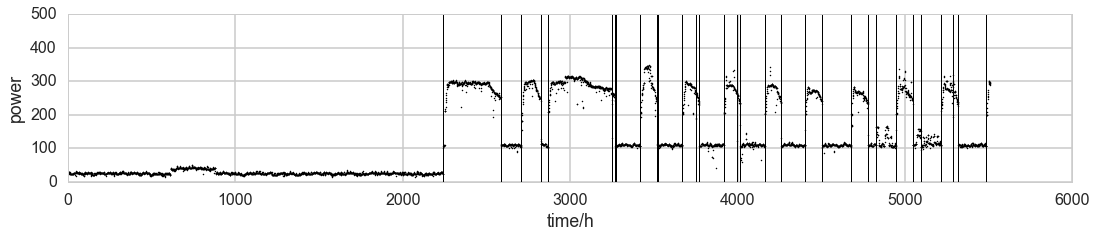

In [156]:
plt.figure(figsize=[18,3])
plt.plot(t, data, 'k.', markersize=3)
for cp in cp_list:
    plt.plot([t[cp],t[cp]], [0,500], 'k-', linewidth=1)
plt.xlabel('time/h')
plt.ylabel('power')

# plt.xlim([16.6,16.8])

11020

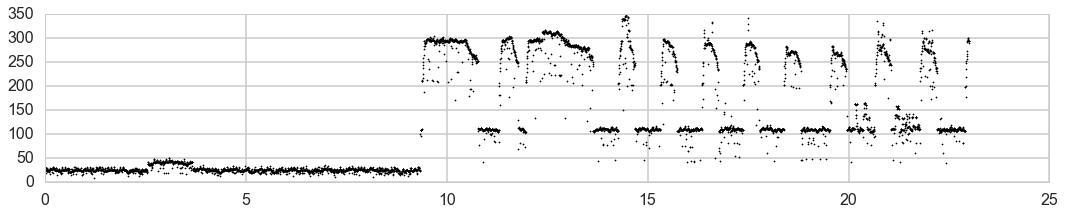

In [120]:
t, data = read_dat_0819(datetime.date(2016,6,2), 0, 23, '../new_data/IHG')
_, data = rel_change_filter_0819_3(range(len(data)), data)
plt.figure(figsize=[18,3])

plt.plot(t, data, 'k.', markersize=3)
len(data)


In [119]:
4 * 60 * 24

5760

In [ ]:
def rel_change_filter_0819_3(t, data_input, thre=.2):
    """
    filter data based on relative change
    data points in data_input that below or above both neighbouring points
    and have relative change above thre will be set as the average of neighbouring data.
    """
    thre_2 = thre/(1-thre)
    id_filter = [i for i in range(1, len(data_input)-1) 
     if (data_input[i]>data_input[i-1] and data_input[i]>data_input[i+1] and rel_change(data_input[i-1:i+2])>thre) or
                 (data_input[i]<data_input[i-1] and data_input[i]<data_input[i+1] and rel_change(data_input[i-1:i+2])>thre_2)
    ]
    data_input_2 = [(data_input[i-1]+data_input[i+1])/2 if (i in id_filter) else dat for i, dat in enumerate(data_input) ]
    return t, data_input_2